In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Sun Nov  6 13:25:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    43W / 350W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
! pip -qq install git+https://github.com/qubvel/segmentation_models.pytorch

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 58 kB 40 kB/s 
     |████████████████████████████████| 376 kB 47.2 MB/s 


In [4]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils import metrics
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from google.colab import drive
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import albumentations as A
import torch.nn.functional as F
import pandas as pd
import nibabel as nib
from tqdm import tqdm

In [5]:
!7za x TrainSet.zip


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,12 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (50657),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 3693478666 bytes (3523 MiB)

Extracting archive: TrainSet.zip
--
Path = TrainSet.zip
Type = zip
Physical Size = 3693478666

  0%      0% 15 - TrainSet/UCSF-PDGM-0008/UCSF-PDGM-0008_T1c.nii.gz                                                             1% 31 - TrainSet/UCSF-PDGM-0012/UCSF-PDGM-0012_FLAIR.nii.gz                                                               2% 46 - TrainSet/UCSF-PDGM-0014/UCSF-PDGM-0014_T2.nii.gz

In [6]:
!7za x TestSet.zip


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,12 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (50657),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 900960358 bytes (860 MiB)

Extracting archive: TestSet.zip
--
Path = TestSet.zip
Type = zip
Physical Size = 900960358

  0%      3% 14 - TestSet/UCSF-PDGM-0019/UCSF-PDGM-0019_T1.nii.gz                                                           6% 27 - TestSet/UCSF-PDGM-0030/UCSF-PDGM-0030_T1c.nii.gz                                                            9% 40 - TestSet/UCSF-PDGM-0048/UCSF-PDGM-0048_T2.nii.gz           

In [7]:
DataPath_train = '/content/TrainSet'

In [ ]:
subject_train = []
subject_dir_train = []
image_T1_train = []
image_T1c_train = []
image_T2_train = []
image_Flair_train = []
image_Mask_train = []
image_Path_train = {
              'Segmentation': [],    
              'T1': [],
              'T1c': [],
              'T2': [],
              'FLAIR': []
          }

def findFiles(file_path):
    files = os.listdir(file_path) 
    for file_name in files:
        npath = file_path + '/' + file_name                                
        if "tumor_segmentation" in file_name: 
          subject_train.append(str(file_name).split("_")[0])
          image_Mask_train.append(file_name)
          image_T1_train.append(file_name.replace("tumor_segmentation","T1"))   
          image_T1c_train.append(file_name.replace("tumor_segmentation","T1c")) 
          image_T2_train.append(file_name.replace("tumor_segmentation","T2")) 
          image_Flair_train.append(file_name.replace("tumor_segmentation","FLAIR"))
          image_Path_train['Segmentation'].append(npath)
          image_Path_train['T1'].append(npath.replace("tumor_segmentation","T1"))   
          image_Path_train['T1c'].append(npath.replace("tumor_segmentation","T1c")) 
          image_Path_train['T2'].append(npath.replace("tumor_segmentation","T2")) 
          image_Path_train['FLAIR'].append(npath.replace("tumor_segmentation","FLAIR"))    
        if os.path.isdir(npath):   
            if file_name[0] == '.':
                pass
            else:
                findFiles(npath)
findFiles(DataPath_train)              

In [9]:
df_summary_train = pd.DataFrame({'subjects':subject_train, 'T1':image_T1_train, 'T1c':image_T1c_train, 'T2':image_T2_train, 'FLAIR':image_Flair_train, 'masks':image_Mask_train})
df_summary_train.head(10)

,subjects,T1,T1c,T2,FLAIR,masks
0,UCSF-PDGM-0416,UCSF-PDGM-0416_T1.nii.gz,UCSF-PDGM-0416_T1c.nii.gz,UCSF-PDGM-0416_T2.nii.gz,UCSF-PDGM-0416_FLAIR.nii.gz,UCSF-PDGM-0416_tumor_segmentation.nii.gz
1,UCSF-PDGM-0010,UCSF-PDGM-0010_T1.nii.gz,UCSF-PDGM-0010_T1c.nii.gz,UCSF-PDGM-0010_T2.nii.gz,UCSF-PDGM-0010_FLAIR.nii.gz,UCSF-PDGM-0010_tumor_segmentation.nii.gz
2,UCSF-PDGM-0066,UCSF-PDGM-0066_T1.nii.gz,UCSF-PDGM-0066_T1c.nii.gz,UCSF-PDGM-0066_T2.nii.gz,UCSF-PDGM-0066_FLAIR.nii.gz,UCSF-PDGM-0066_tumor_segmentation.nii.gz
3,UCSF-PDGM-0533,UCSF-PDGM-0533_T1.nii.gz,UCSF-PDGM-0533_T1c.nii.gz,UCSF-PDGM-0533_T2.nii.gz,UCSF-PDGM-0533_FLAIR.nii.gz,UCSF-PDGM-0533_tumor_segmentation.nii.gz
4,UCSF-PDGM-0362,UCSF-PDGM-0362_T1.nii.gz,UCSF-PDGM-0362_T1c.nii.gz,UCSF-PDGM-0362_T2.nii.gz,UCSF-PDGM-0362_FLAIR.nii.gz,UCSF-PDGM-0362_tumor_segmentation.nii.gz
5,UCSF-PDGM-0410,UCSF-PDGM-0410_T1.nii.gz,UCSF-PDGM-0410_T1c.nii.gz,UCSF-PDGM-0410_T2.nii.gz,UCSF-PDGM-0410_FLAIR.nii.gz,UCSF-PDGM-0410_tumor_segmentation.nii.gz
6,UCSF-PDGM-0306,UCSF-PDGM-0306_T1.nii.gz,UCSF-PDGM-0306_T1c.nii.gz,UCSF-PDGM-0306_T2.nii.gz,UCSF-PDGM-0306_FLAIR.nii.gz,UCSF-PDGM-0306_tumor_segmentation.nii.gz
7,UCSF-PDGM-0481,UCSF-PDGM-0481_T1.nii.gz,UCSF-PDGM-0481_T1c.nii.gz,UCSF-PDGM-0481_T2.nii.gz,UCSF-PDGM-0481_FLAIR.nii.gz,UCSF-PDGM-0481_tumor_segmentation.nii.gz
8,UCSF-PDGM-0510,UCSF-PDGM-0510_T1.nii.gz,UCSF-PDGM-0510_T1c.nii.gz,UCSF-PDGM-0510_T2.nii.gz,UCSF-PDGM-0510_FLAIR.nii.gz,UCSF-PDGM-0510_tumor_segmentation.nii.gz
9,UCSF-PDGM-0313,UCSF-PDGM-0313_T1.nii.gz,UCSF-PDGM-0313_T1c.nii.gz,UCSF-PDGM-0313_T2.nii.gz,UCSF-PDGM-0313_FLAIR.nii.gz,UCSF-PDGM-0313_tumor_segmentation.nii.gz


In [10]:
len(df_summary_train)

300

In [11]:
DataPath_test = '/content/TestSet'

In [ ]:
subject_test = []
subject_dir_test = []
image_T1_test = []
image_T1c_test = []
image_T2_test = []
image_Flair_test = []
image_Mask_test = []
image_Path_test = {
              'Segmentation': [],    
              'T1': [],
              'T1c': [],
              'T2': [],
              'FLAIR': []
          }
def findFiles(file_path):
    files = os.listdir(file_path)
    for file_name in files:
        npath = file_path + '/' + file_name                                 
        if "tumor_segmentation" in file_name:
          subject_test.append(str(file_name).split("_")[0])
          subject_dir_test = file_path
          image_Mask_test.append(file_name)
          image_T1_test.append(file_name.replace("tumor_segmentation","T1"))   
          image_T1c_test.append(file_name.replace("tumor_segmentation","T1c")) 
          image_T2_test.append(file_name.replace("tumor_segmentation","T2")) 
          image_Flair_test.append(file_name.replace("tumor_segmentation","FLAIR"))
          image_Path_test['Segmentation'].append(npath)
          image_Path_test['T1'].append(npath.replace("tumor_segmentation","T1"))   
          image_Path_test['T1c'].append(npath.replace("tumor_segmentation","T1c")) 
          image_Path_test['T2'].append(npath.replace("tumor_segmentation","T2")) 
          image_Path_test['FLAIR'].append(npath.replace("tumor_segmentation","FLAIR"))    
        if os.path.isdir(npath):   
            if file_name[0] == '.':
                pass
            else:
                findFiles(npath)
     
findFiles(DataPath_test) 

In [13]:
df_summary_test = pd.DataFrame({'subjects':subject_test, 'T1':image_T1_test, 'T1c':image_T1c_test, 'T2':image_T2_test, 'FLAIR':image_Flair_test, 'masks':image_Mask_test})
df_summary_test.head(10)

,subjects,T1,T1c,T2,FLAIR,masks
0,UCSF-PDGM-0406,UCSF-PDGM-0406_T1.nii.gz,UCSF-PDGM-0406_T1c.nii.gz,UCSF-PDGM-0406_T2.nii.gz,UCSF-PDGM-0406_FLAIR.nii.gz,UCSF-PDGM-0406_tumor_segmentation.nii.gz
1,UCSF-PDGM-0291,UCSF-PDGM-0291_T1.nii.gz,UCSF-PDGM-0291_T1c.nii.gz,UCSF-PDGM-0291_T2.nii.gz,UCSF-PDGM-0291_FLAIR.nii.gz,UCSF-PDGM-0291_tumor_segmentation.nii.gz
2,UCSF-PDGM-0383,UCSF-PDGM-0383_T1.nii.gz,UCSF-PDGM-0383_T1c.nii.gz,UCSF-PDGM-0383_T2.nii.gz,UCSF-PDGM-0383_FLAIR.nii.gz,UCSF-PDGM-0383_tumor_segmentation.nii.gz
3,UCSF-PDGM-0064,UCSF-PDGM-0064_T1.nii.gz,UCSF-PDGM-0064_T1c.nii.gz,UCSF-PDGM-0064_T2.nii.gz,UCSF-PDGM-0064_FLAIR.nii.gz,UCSF-PDGM-0064_tumor_segmentation.nii.gz
4,UCSF-PDGM-0537,UCSF-PDGM-0537_T1.nii.gz,UCSF-PDGM-0537_T1c.nii.gz,UCSF-PDGM-0537_T2.nii.gz,UCSF-PDGM-0537_FLAIR.nii.gz,UCSF-PDGM-0537_tumor_segmentation.nii.gz
5,UCSF-PDGM-0113,UCSF-PDGM-0113_T1.nii.gz,UCSF-PDGM-0113_T1c.nii.gz,UCSF-PDGM-0113_T2.nii.gz,UCSF-PDGM-0113_FLAIR.nii.gz,UCSF-PDGM-0113_tumor_segmentation.nii.gz
6,UCSF-PDGM-0142,UCSF-PDGM-0142_T1.nii.gz,UCSF-PDGM-0142_T1c.nii.gz,UCSF-PDGM-0142_T2.nii.gz,UCSF-PDGM-0142_FLAIR.nii.gz,UCSF-PDGM-0142_tumor_segmentation.nii.gz
7,UCSF-PDGM-0130,UCSF-PDGM-0130_T1.nii.gz,UCSF-PDGM-0130_T1c.nii.gz,UCSF-PDGM-0130_T2.nii.gz,UCSF-PDGM-0130_FLAIR.nii.gz,UCSF-PDGM-0130_tumor_segmentation.nii.gz
8,UCSF-PDGM-0181,UCSF-PDGM-0181_T1.nii.gz,UCSF-PDGM-0181_T1c.nii.gz,UCSF-PDGM-0181_T2.nii.gz,UCSF-PDGM-0181_FLAIR.nii.gz,UCSF-PDGM-0181_tumor_segmentation.nii.gz
9,UCSF-PDGM-0479,UCSF-PDGM-0479_T1.nii.gz,UCSF-PDGM-0479_T1c.nii.gz,UCSF-PDGM-0479_T2.nii.gz,UCSF-PDGM-0479_FLAIR.nii.gz,UCSF-PDGM-0479_tumor_segmentation.nii.gz


In [14]:
len(df_summary_test)

74

In [15]:
def loadimg(imgpath):
    return nib.load(imgpath).get_fdata()

def ccentre(imgslice, cropx, cropy):
    y, x = imgslice.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)    
    return imgslice[starty:starty + cropy, startx:startx + cropx]

def normalizer(imgslice):
    return (imgslice - imgslice.mean()) / imgslice.std()

In [16]:
! mkdir DatasetTrain
! mkdir DatasetTrain/T1
! mkdir DatasetTrain/T1c
! mkdir DatasetTrain/T2
! mkdir DatasetTrain/FLAIR
! mkdir DatasetTrain/Segmentation

In [17]:
! mkdir DatasetTest
! mkdir DatasetTest/T1
! mkdir DatasetTest/T1c
! mkdir DatasetTest/T2
! mkdir DatasetTest/FLAIR
! mkdir DatasetTest/Segmentation

In [18]:
numOfImgsSaved_train = 0
imgs_train = {}
image_slice_train = {}

for i in (range(len(image_Path_train['Segmentation']))):
    for name in image_Path_train:
        imgs_train[name] = loadimg(image_Path_train[name][i])
    
    for j in range(155):
        for name in imgs_train:
            image_slice_train[name] = imgs_train[name][:, :, j]
            image_slice_train[name] = ccentre(image_slice_train[name], 224, 224)
        if image_slice_train['Segmentation'].max() > 0:
            for name in ['T1','T2','T1c','FLAIR']:
              image_slice_train[name] = normalizer(image_slice_train[name])
            for name in ['Segmentation']:
              image_slice_train[name] = np.rint(image_slice_train[name])
            for name in image_slice_train:
              np.save(f'./DatasetTrain/{name}/image_{numOfImgsSaved_train}.npy', image_slice_train[name])
            numOfImgsSaved_train += 1

print(numOfImgsSaved_train)

19057


In [19]:
numOfImgsSaved_test = 0
imgs_test = {}
image_slice_test = {}

for i in (range(len(image_Path_test['Segmentation']))):
    for name in image_Path_test:
        imgs_test[name] = loadimg(image_Path_test[name][i])
    
    for j in range(155):
        for name in imgs_test:
            image_slice_test[name] = imgs_test[name][:, :, j]
            image_slice_test[name] = ccentre(image_slice_test[name], 224, 224)
        if image_slice_test['Segmentation'].max() > 0:
            for name in ['T1','T2','T1c','FLAIR']:
              image_slice_test[name] = normalizer(image_slice_test[name])
            for name in ['Segmentation']:
              image_slice_test[name] = np.rint(image_slice_test[name])
            for name in image_slice_test:
              np.save(f'./DatasetTest/{name}/image_{numOfImgsSaved_test}.npy', image_slice_test[name])
            numOfImgsSaved_test += 1

print(numOfImgsSaved_test)

4820


Text(0.5, 1.0, 'T2')

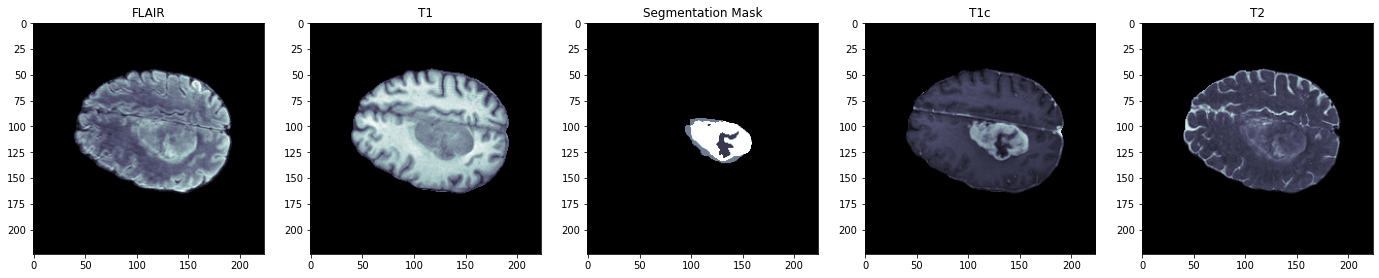

In [33]:
index = 1215

fig = plt.figure(figsize = (24, 15))
plt.subplot(1, 5, 1)
plt.imshow(np.load('DatasetTrain/FLAIR/image_' + str(index) + '.npy'), cmap = 'bone')
plt.title('FLAIR')

plt.subplot(1, 5, 2)
plt.imshow(np.load('DatasetTrain/T1/image_' + str(index) + '.npy'), cmap = 'bone')
plt.title('T1')

plt.subplot(1, 5, 3)
plt.imshow(np.load('DatasetTrain/Segmentation/image_' + str(index) + '.npy'), cmap = 'bone')
plt.title('Segmentation Mask')

plt.subplot(1, 5, 4)
plt.imshow(np.load('DatasetTrain/T1c/image_' + str(index) + '.npy'), cmap = 'bone')
plt.title('T1c')

plt.subplot(1, 5, 5)
plt.imshow(np.load('DatasetTrain/T2/image_' + str(index) + '.npy'), cmap = 'bone')
plt.title('T2')

Text(0.5, 1.0, 'FLAIR (T2 Mask)')

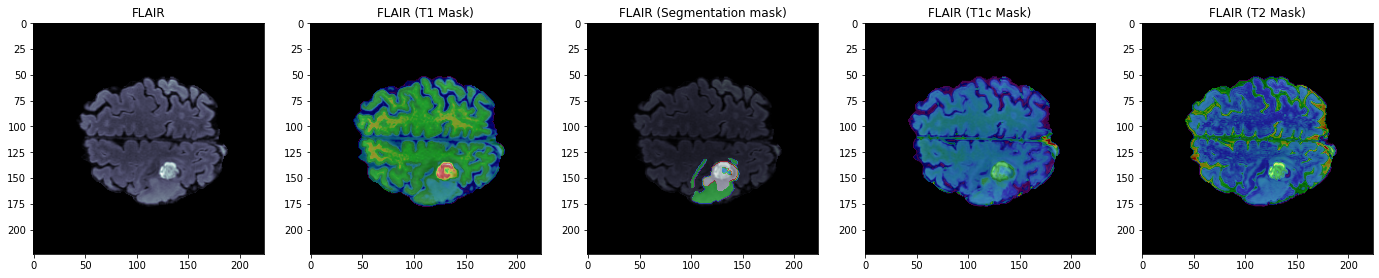

In [21]:
index = 25

fig = plt.figure(figsize = (24, 15))
plt.subplot(1, 5, 1)
plt.imshow(np.load('DatasetTrain/FLAIR/image_' + str(index) + '.npy'), cmap = 'bone')
plt.title('FLAIR')

plt.subplot(1, 5, 2)
plt.imshow(np.load('DatasetTrain/FLAIR/image_' + str(index) + '.npy'), cmap = 'bone')
plt.imshow(np.load('DatasetTrain/T1/image_' + str(index) + '.npy'), alpha = 0.5, cmap = 'nipy_spectral')
plt.title('FLAIR (T1 Mask)')

plt.subplot(1, 5, 3)
plt.imshow(np.load('DatasetTrain/FLAIR/image_' + str(index) + '.npy'), cmap = 'bone')
plt.imshow(np.load('DatasetTrain/Segmentation/image_' + str(index) + '.npy'), alpha = 0.5, cmap = 'nipy_spectral')
plt.title('FLAIR (Segmentation mask)')

plt.subplot(1, 5, 4)
plt.imshow(np.load('DatasetTrain/FLAIR/image_' + str(index) + '.npy'), cmap = 'bone')
plt.imshow(np.load('DatasetTrain/T1c/image_' + str(index) + '.npy'), alpha = 0.5, cmap = 'nipy_spectral')
plt.title('FLAIR (T1c Mask)')

plt.subplot(1, 5, 5)
plt.imshow(np.load('DatasetTrain/FLAIR/image_' + str(index) + '.npy'), cmap = 'bone')
plt.imshow(np.load('DatasetTrain/T2/image_' + str(index) + '.npy'), alpha = 0.5, cmap = 'nipy_spectral')
plt.title('FLAIR (T2 Mask)')

In [95]:
class Dataset(Dataset):

    CLASSES = ['edema', 'tumour', 'cysy']
    
    def __init__(self, datapath, augmentation = None, classes = None):
        self.augmentation = augmentation
        self.class_values = [self.CLASSES.index(I.lower()) for I in classes]
        self.folderpaths = {
                              'mask_edema': os.path.join(datapath, 'Segmentation/'),
                              'mask_cysy': os.path.join(datapath, 'Segmentation/'),
                              'mask_tumour': os.path.join(datapath, 'Segmentation/'),
                              't1': os.path.join(datapath, 'T1/'),
                              't1c': os.path.join(datapath, 'T1c/'),
                              't2': os.path.join(datapath, 'T2/'),
                              'flair': os.path.join(datapath, 'FLAIR/')
                          }
    
    def __getitem__(self, idx):
        images = {}
        for name in self.folderpaths:
            images[name] = np.load(os.path.join(self.folderpaths[name], f'image_{idx}.npy'))

        if self.augmentation:
            images = self.augmentation(
                                        image = images['flair'],
                                        mask_edema = images['mask_edema'],
                                        mask_tumour = images['mask_tumour'],
                                        mask_cysy = images['mask_cysy'],
                                        t1 = images['t1'],
                                        t1c = images['t1c'],
                                        t2 = images['t2'] )
            images['flair'] = images['image']

        for name in images:
            images[name] = torch.from_numpy(images[name])

        # stacking multi ins
        images_input = torch.stack(
                                [images['t1'],
                                images['t1c'],
                                images['t2'],
                                images['flair']], dim = 0
                            )
        
        # Edema 127
        images['mask_edema'][images['mask_edema'] == 4] = 0 # 255 = 0
        images['mask_edema'][images['mask_edema'] == 1] = 0 # 64 = 0
        images['mask_edema'][images['mask_edema'] == 2] = 1 # 127 = 1

        # Tumour 255
        images['mask_tumour'][images['mask_tumour'] == 1] = 0 # 64 = 0
        images['mask_tumour'][images['mask_tumour'] == 2] = 0 # 127 = 0
        images['mask_tumour'][images['mask_tumour'] == 4] = 1 # 255 = 1

        # Cysy 64
        images['mask_cysy'][images['mask_cysy'] == 4] = 0 # 255 = 0
        images['mask_cysy'][images['mask_cysy'] == 2] = 0 # 127 = 0
        images['mask_cysy'][images['mask_cysy'] == 1] = 1 # 64 = 1
        
        masks_input = torch.stack([images['mask_edema'],images['mask_tumour'],images['mask_cysy']], dim = 0)
        return images_input.float(), masks_input.float()
    
    def __len__(self):
        return len(os.listdir(self.folderpaths['mask_edema'])) - 1

In [96]:
# Tune-able
augmentation = A.Compose([
    A.OneOf([
                A.ElasticTransform(alpha = 120, sigma = 120 * 0.05, alpha_affine = 120 * 0.03, p = 0.5),
                A.GridDistortion(p = 0.5),
                A.OpticalDistortion(distort_limit = 2, shift_limit = 0.5, p = 0.5)                  
            ], p = 0.8),
    A.RandomBrightnessContrast(p = 0.8)], 
    additional_targets = {'t1':'image', 't1c':'image', 't2':'image'}
                         )

train_dataset = Dataset(datapath = './DatasetTrain/', augmentation = None, classes = ['edema', 'tumour', 'cysy'])

# 60%/20%/20% 
train_length = int(len(train_dataset)*0.75)
valid_length = int(len(train_dataset)*0.25)

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, (train_length, valid_length), generator=torch.Generator().manual_seed(42))

In [97]:
test_dataset = Dataset(datapath = './DatasetTest/', augmentation = None, classes = ['edema', 'tumour', 'cysy'])

In [98]:
len(train_dataset),len(valid_dataset)

(14292, 4764)

In [99]:
len(test_dataset)

4819

In [100]:
train_loader = DataLoader(train_dataset,
                      batch_size=128,
                      num_workers=12,
                      shuffle=False)

valid_loader = DataLoader(valid_dataset,
                      batch_size=128,
                      num_workers=12,
                      shuffle=False)

In [101]:
test_loader = DataLoader(test_dataset,
                      batch_size=128,
                      num_workers=2,
                      shuffle=False)

Text(0.5, 1.0, 'GTMask')

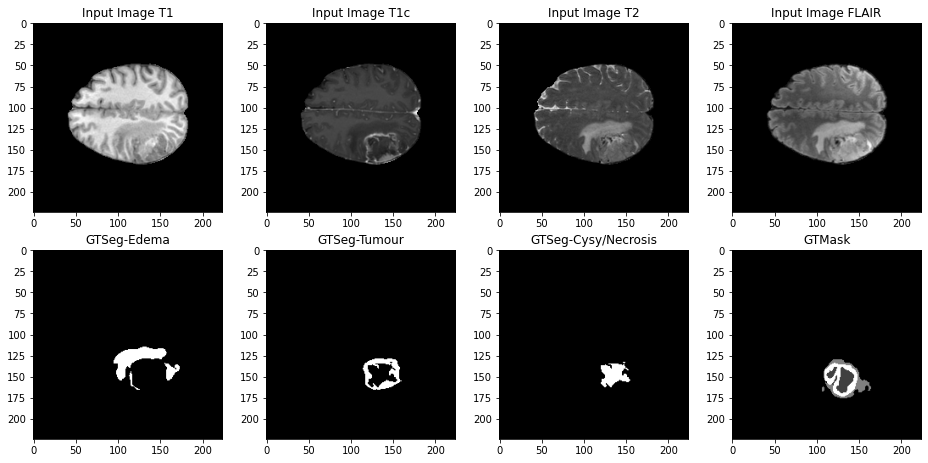

In [113]:
index = 874

image, gt_mask = train_dataset[index]

plt.figure(figsize = (16, 16))

plt.subplot(4, 4, 1)
plt.imshow(image[0,:,:],cmap='gray')
plt.title('Input Image T1')
plt.subplot(4, 4, 2)
plt.imshow(image[1,:,:],cmap='gray')
plt.title('Input Image T1c')
plt.subplot(4, 4, 3)
plt.imshow(image[2,:,:],cmap='gray')
plt.title('Input Image T2')
plt.subplot(4, 4, 4)
plt.imshow(image[3,:,:],cmap='gray')
plt.title('Input Image FLAIR')

plt.subplot(4, 4, 5)
plt.imshow(gt_mask[0,:,:],cmap='gray')
plt.title('GTSeg-Edema')
plt.subplot(4, 4, 6)
plt.imshow(gt_mask[1,:,:],cmap='gray')
plt.title('GTSeg-Tumour')
plt.subplot(4, 4, 7)
plt.imshow(gt_mask[2,:,:],cmap='gray')
plt.title('GTSeg-Cysy/Necrosis')
plt.subplot(4, 4, 8)
plt.imshow(np.load('DatasetTrain/Segmentation/image_' + str(index) + '.npy'), cmap = 'gray')
plt.title('GTMask')

In [104]:
# importing model
MODEL = smp.Unet(encoder_name='resnet50',
                 encoder_depth=5,
                 encoder_weights='imagenet',
                 decoder_channels=[1024,512,256,128,64],
                 in_channels=4,
                 classes=3,
                 activation=None)

In [105]:
backgroundchannel = [0]

DICE_LOSS = smp.utils.losses.DiceLoss(activation = 'sigmoid')  

OPTIMIZER = torch.optim.Adam([ 
                                dict(params=MODEL.parameters(), lr = 0.0001),
                             ])
METRICS = [
              metrics.IoU(threshold = 0.5,ignore_channels = backgroundchannel, activation = 'sigmoid'),
              metrics.Fscore(ignore_channels = backgroundchannel, activation = 'sigmoid'),
          ]

In [106]:
train_epoch = smp.utils.train.TrainEpoch(
                                            model = MODEL,
                                            loss = DICE_LOSS,
                                            metrics = [],
                                            optimizer = OPTIMIZER,
                                            device = "cuda",
                                            verbose = True
                                        )
valid_epoch = smp.utils.train.ValidEpoch(
                                            model = MODEL,
                                            loss = DICE_LOSS,
                                            metrics = METRICS,
                                            device = "cuda",
                                            verbose = True
                                        )

max_dice_score = 1
stats = {
          'train_loss' : [],
          'valid_loss' : [],
          'fscore' : [],
          'iou_score' : []
        }

for i in range(200):
  print(f'\n --- Epoch {i} --- ')
  train_logs = train_epoch.run(train_loader)
  valid_logs = valid_epoch.run(valid_loader)
  
  if max_dice_score > valid_logs['dice_loss']:
      max_dice_score = valid_logs['dice_loss']
      torch.save(MODEL.state_dict(), f'./model.pth')
      print('model saved!')
  
  # loss statistics
  stats['train_loss'].append(train_logs['dice_loss'])
  stats['valid_loss'].append(valid_logs['dice_loss'])

  # metric statistics
  stats['fscore'].append(valid_logs['fscore'])
  stats['iou_score'].append(valid_logs['iou_score'])
  np.save(f'./model.npy', stats)


 --- Epoch 0 --- 
valid: 100%|██████████| 38/38 [00:30<00:00,  1.24it/s, dice_loss - 0.7251, iou_score - 0.4645, fscore - 0.6343]
model saved!

 --- Epoch 1 --- 
valid: 100%|██████████| 38/38 [00:12<00:00,  3.01it/s, dice_loss - 0.2272, iou_score - 0.6308, fscore - 0.7736]
model saved!

 --- Epoch 2 --- 
valid: 100%|██████████| 38/38 [00:12<00:00,  3.00it/s, dice_loss - 0.1751, iou_score - 0.623, fscore - 0.7677]
model saved!

 --- Epoch 3 --- 
valid: 100%|██████████| 38/38 [00:12<00:00,  2.95it/s, dice_loss - 0.1627, iou_score - 0.6556, fscore - 0.7919]
model saved!

 --- Epoch 4 --- 
valid: 100%|██████████| 38/38 [00:12<00:00,  3.03it/s, dice_loss - 0.09235, iou_score - 0.8529, fscore - 0.9205]
model saved!

 --- Epoch 5 --- 
valid: 100%|██████████| 38/38 [00:12<00:00,  2.99it/s, dice_loss - 0.08423, iou_score - 0.8632, fscore - 0.9265]
model saved!

 --- Epoch 6 --- 
valid: 100%|██████████| 38/38 [00:12<00:00,  3.02it/s, dice_loss - 0.07864, iou_score - 0.8718, fscore - 0.9315]
mod

KeyboardInterrupt: ignored

In [107]:
MODEL.load_state_dict(torch.load('/content/drive/MyDrive/4C3C/ep78/model.pth'))

<All keys matched successfully>

In [108]:
test_epoch = smp.utils.train.ValidEpoch(
    model=MODEL,
    loss=DICE_LOSS,
    metrics=METRICS,
    device="cuda",
)
logs = test_epoch.run(test_loader)

valid: 100%|██████████| 38/38 [00:43<00:00,  1.15s/it, dice_loss - 0.1354, iou_score - 0.7926, fscore - 0.8812]


Text(0.5, 1.0, 'Prediction-3')

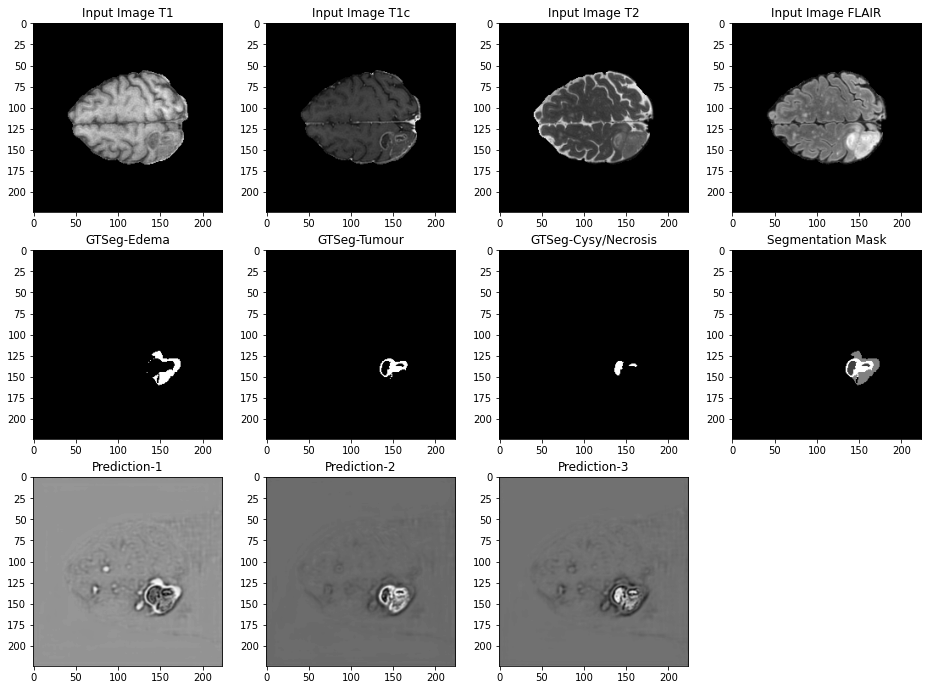

In [118]:
index = 47

image, gt_mask = test_dataset[index]
x_tensor = torch.from_numpy(np.asarray(image)).to("cuda").unsqueeze(0)
predict_mask = MODEL.predict(x_tensor)
predict_mask = (predict_mask.squeeze().cpu().numpy().round())


predict_mask_B = np.zeros([3,224,224])
for i in range(224):
  for j in range(224):
      for k in range(3):
        if predict_mask[k,i,j]>=0.5:
           predict_mask_B[k,i,j] = 1
        else :
           predict_mask_B[k,i,j] = 0

predict_mask_B_stack = np.zeros([224,224])
for i in range(224):
  for j in range(224):
        if  predict_mask_B[2,i,j]>=0.5:
           predict_mask_B_stack[i,j] = 1
        elif predict_mask_B[1,i,j]>=0.5:
           predict_mask_B_stack[i,j] = 4
        elif predict_mask_B[0,i,j]>=0.5:
           predict_mask_B_stack[i,j] = 2
        else:
           predict_mask_B_stack[i,j] = 0

plt.figure(figsize = (16, 16))

plt.subplot(4, 4, 1)
plt.imshow(image[0,:,:],cmap='gray')
plt.title('Input Image T1')
plt.subplot(4, 4, 2)
plt.imshow(image[1,:,:],cmap='gray')
plt.title('Input Image T1c')
plt.subplot(4, 4, 3)
plt.imshow(image[2,:,:],cmap='gray')
plt.title('Input Image T2')
plt.subplot(4, 4, 4)
plt.imshow(image[3,:,:],cmap='gray')
plt.title('Input Image FLAIR')

plt.subplot(4, 4, 5)
plt.imshow(gt_mask[0,:,:],cmap='gray')
plt.title('GTSeg-Edema')
plt.subplot(4, 4, 6)
plt.imshow(gt_mask[1,:,:],cmap='gray')
plt.title('GTSeg-Tumour')
plt.subplot(4, 4, 7)
plt.imshow(gt_mask[2,:,:],cmap='gray')
plt.title('GTSeg-Cysy/Necrosis')
plt.subplot(4, 4, 8)
plt.imshow(np.load('DatasetTest/Segmentation/image_' + str(index) + '.npy'), cmap = 'gray')
plt.title('Segmentation Mask')


plt.subplot(4, 4, 9)
plt.imshow(predict_mask[0,:,:], cmap = 'gray')
plt.title('Prediction-edema')
plt.subplot(4, 4, 10)
plt.imshow(predict_mask[1,:,:], cmap = 'gray')
plt.title('Prediction-tumour')
plt.subplot(4, 4, 11)
plt.imshow(predict_mask[2,:,:], cmap = 'gray')
plt.title('Prediction-cysy')
plt.subplot(4, 4, 12)
plt.imshow(predict_mask[0,:,:], cmap = 'gray', alpha = 0.5)
plt.imshow(predict_mask[1,:,:], cmap = 'gray', alpha = 0.75)
plt.imshow(predict_mask[2,:,:], cmap = 'gray', alpha = 0.25)
plt.title('Prediction-stack')

plt.subplot(4, 4, 13)
plt.imshow(predict_mask_B[0,:,:], cmap = 'gray')
plt.title('Prediction-edema_binary')
plt.subplot(4, 4, 14)
plt.imshow(predict_mask_B[1,:,:], cmap = 'gray')
plt.title('Prediction-tumour_binary')
plt.subplot(4, 4, 15)
plt.imshow(predict_mask_B[2,:,:], cmap = 'gray')
plt.title('Prediction-cysy_binary')
plt.subplot(4, 4, 16)
plt.imshow(predict_mask_B_stack, cmap = 'gray')
plt.title('Prediction-stack_binary')
